# Data Preprocessing

### Import required packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
pd.pandas.set_option("display.max_columns", None)

In [3]:
df = pd.read_csv(r'dataset/EasyVisa.csv')
df.head()

,case_id,continent,education_of_employee,has_job_experience,requires_job_training,no_of_employees,yr_of_estab,region_of_employment,prevailing_wage,unit_of_wage,full_time_position,case_status
0,EZYV01,Asia,High School,N,N,14513,2007,West,592.2029,Hour,Y,Denied
1,EZYV02,Asia,Master's,Y,N,2412,2002,Northeast,83425.6500,Year,Y,Certified
2,EZYV03,Asia,Bachelor's,N,Y,44444,2008,West,122996.8600,Year,Y,Denied
3,EZYV04,Asia,Bachelor's,N,N,98,1897,West,83434.0300,Year,Y,Denied
4,EZYV05,Africa,Master's,Y,N,1082,2005,South,149907.3900,Year,Y,Certified


In [4]:
df.shape

(25480, 12)

## Data cleaning

* Handling missing values
* Handling duplicate values
* Check datatype of columns

### 1.1 Check Null values

In [5]:
df.isna().sum()

case_id                  0
continent                0
education_of_employee    0
has_job_experience       0
requires_job_training    0
no_of_employees          0
yr_of_estab              0
region_of_employment     0
prevailing_wage          0
unit_of_wage             0
full_time_position       0
case_status              0
dtype: int64

**NO null values present**

### 1.2 Check for duplicate records

In [6]:
df.duplicated().sum()

0

**NO record is duplicated**

In [7]:
# Removeing case_id as it refer to unique id
df.drop(columns=['case_id'],inplace =True)

## Feature Engineering

### Feature Extraction

In [8]:
df.head()

,continent,education_of_employee,has_job_experience,requires_job_training,no_of_employees,yr_of_estab,region_of_employment,prevailing_wage,unit_of_wage,full_time_position,case_status
0,Asia,High School,N,N,14513,2007,West,592.2029,Hour,Y,Denied
1,Asia,Master's,Y,N,2412,2002,Northeast,83425.6500,Year,Y,Certified
2,Asia,Bachelor's,N,Y,44444,2008,West,122996.8600,Year,Y,Denied
3,Asia,Bachelor's,N,N,98,1897,West,83434.0300,Year,Y,Denied
4,Africa,Master's,Y,N,1082,2005,South,149907.3900,Year,Y,Certified


In [9]:
# using yr_of_estab we can find how old employer's company is
from  datetime import date

today_date = date.today()
current_year = today_date.year
current_year

2025

In [10]:
df['company_age'] = current_year - df['yr_of_estab'] 
df['company_age']

0         18
1         23
2         17
3        128
4         20
        ... 
25475     17
25476     19
25477    115
25478    138
25479     65
Name: company_age, Length: 25480, dtype: int64

In [11]:
# now we can drop yr_of_estab ,as company_age convey same information
df.drop(columns=['yr_of_estab'],inplace =True)

### Type of Features

##### Numerical Features

In [12]:
numerical_features = [feature for feature in df.columns if df[feature].dtype != 'O']
numerical_features

['no_of_employees', 'prevailing_wage', 'company_age']

In [13]:
# contineous feature
contineous_features = [feature for feature in numerical_features if len(df[feature].value_counts()) > 25]
descrete_features = [feature for feature in numerical_features if len(df[feature].value_counts()) <= 25]
print(f'contineous_features : {contineous_features}')
print(f'descrete_features : {descrete_features}')

contineous_features : ['no_of_employees', 'prevailing_wage', 'company_age']
descrete_features : []


#### Categorical Features

In [14]:
categorical_features = [feature for feature in df.columns if df[feature].dtype == 'O']
categorical_features

['continent',
 'education_of_employee',
 'has_job_experience',
 'requires_job_training',
 'region_of_employment',
 'unit_of_wage',
 'full_time_position',
 'case_status']

## Split dataset into X(Independet features),y(dependent features)

In [30]:
X = df.drop(columns=['case_status'])
y= df['case_status']
X.shape,y.shape

((25480, 10), (25480,))

#### Manually encoding `case_status`

In [16]:
y.value_counts()

case_status
Certified    17018
Denied        8462
Name: count, dtype: int64

In [56]:
# Denied->1 ,certified -> 0
y = np.where(y=='Denied',1,0)

In [57]:
y

array([1, 0, 1, ..., 0, 0, 0])

## Feature Transformation

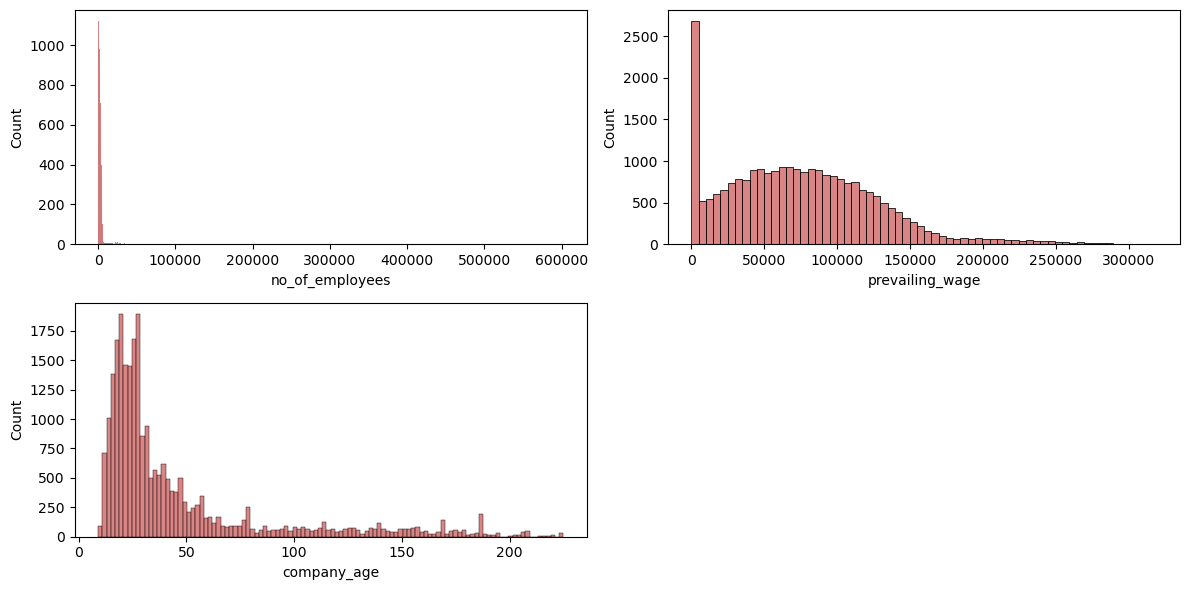

In [19]:
plt.figure(figsize=(12,6))
for i, col in enumerate(numerical_features):
    plt.subplot(2,2,i+1)
    sns.histplot(x=X[col],color='indianred')
    plt.xlabel(col)
    plt.tight_layout()

* No of employees and Copmany age column is skewed
* Apply a power transform featurewise to make data more Gaussian-like.

Power transforms are a family of parametric, monotonic transformations that are applied to make data more Gaussian-like. This is useful for modeling issues related to heteroscedasticity (non-constant variance), or other situations where normality is desired.

Currently, PowerTransformer supports the Box-Cox transform and the Yeo-Johnson transform.

**Checking Skewness**

What is skewness : Skewness refers to a distortion or asymmetry that deviates from the symmetrical bell curve, or normal distribution, in a set of data. If the curve is shifted to the left or to the right, it is said to be skewed. Skewness can be quantified as a representation of the extent to which a given distribution varies from a normal distribution. A normal distribution has a skew of zero

In [20]:
X[contineous_features].skew(axis = 0 ,skipna=True)

no_of_employees    12.265260
prevailing_wage     0.755776
company_age         2.037301
dtype: float64

* Positiviely Skewed : company_age, no_of_employees.
* We can handle outliers and then check the skewness.

## Apply Power Transformer to Check if it can reduces the outliers¶

In [21]:
from sklearn.preprocessing import PowerTransformer
pt = PowerTransformer(method ='yeo-johnson')
transform_features = ['company_age','no_of_employees']
X_copy = pt.fit_transform(X[transform_features])

In [22]:
X_copy = pd.DataFrame(X_copy, columns=transform_features)

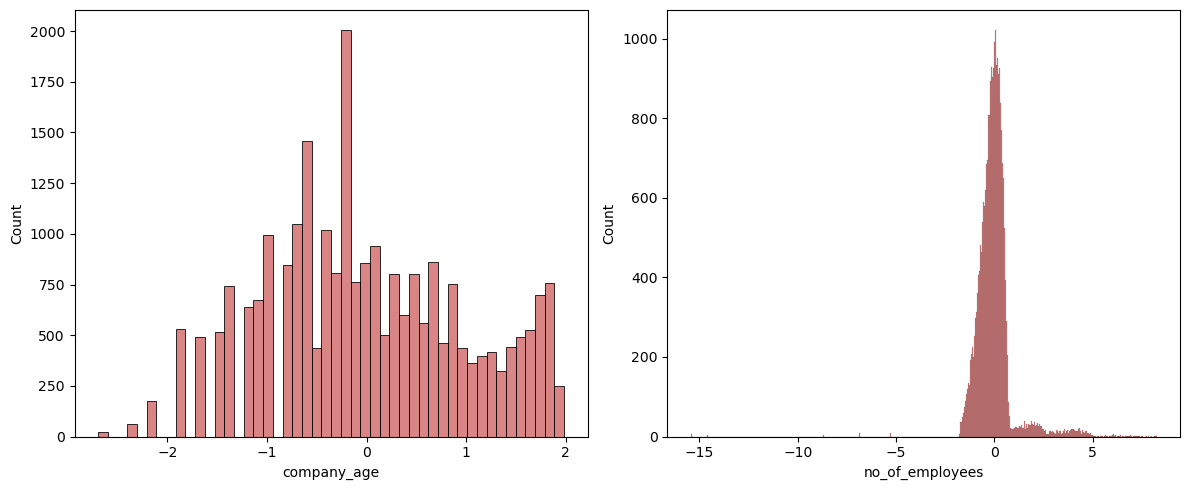

In [23]:
plt.figure(figsize=(12, 5))
for i, col in enumerate(transform_features):
    plt.subplot(1, 2, i+1)
    sns.histplot(x=X_copy[col], color='indianred')
    plt.xlabel(col)
    plt.tight_layout()

**Checking Skewness**

In [24]:
X_copy.skew(axis=0, skipna=True)

company_age        0.112260
no_of_employees    0.399339
dtype: float64

* Here Yeo-Johnson is used and it supports both positive or negative data for transformation.
* So Power Transformer with yeo-johnson can be used.

In [25]:
for feature in categorical_features:
    print(feature,':', df[feature].nunique())

continent : 6
education_of_employee : 4
has_job_experience : 2
requires_job_training : 2
region_of_employment : 5
unit_of_wage : 4
full_time_position : 2
case_status : 2


## Feature Encoding and Scaling

 **One Hot Encoding for Columns which had lesser unique values and not ordinal**
* One hot encoding is a process by which categorical variables are converted into a form that could be provided to ML algorithms to do a better job in prediction.

**Ordinal Encoding for Columns which has many unique categories** 
* Ordinal encoding is used here as label encoder is supported for column transformer.
* Ordinal encoding is used for Ordinal Variable. Variable comprises a finite set of discrete values with a ranked ordering between values.

**Standard Scaler** 
* Standardize features by removing the mean and scaling to unit variance.

**Power Transformer**
* Power transforms are a technique for transforming numerical input or output variables to have a Gaussian or more-Gaussian-like probability distribution.

## Preprocessing
preprocessing using column transformer

In [27]:
# create column transformer with 3 types of transformers
from sklearn.preprocessing import OneHotEncoder, StandardScaler,OrdinalEncoder,PowerTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

ordinal_columns = ['has_job_experience','requires_job_training','full_time_position','education_of_employee']
nominal_columns = ['continent','unit_of_wage','region_of_employment']
numerical_columns = ['no_of_employees','company_age']

ordinal_transformer = OrdinalEncoder()
nominal_transformer = OneHotEncoder()
numerical_transformer = StandardScaler()

transform_pipe = Pipeline(steps=[('transformer',PowerTransformer(method ='yeo-johnson'))])

preprocessor = ColumnTransformer(
    [
        ('OneHotEncoder',nominal_transformer,nominal_columns),
        ('OrdinalEncoder',ordinal_transformer,ordinal_columns),
        ('StandardScaler',numerical_transformer,numerical_columns),
        ('Transformer',transform_pipe,numerical_features)
    ]
)

In [31]:
X = preprocessor.fit_transform(X)
X

array([[ 0.        ,  1.        ,  0.        , ...,  1.51729976,
        -1.93915141, -0.95555058],
       [ 0.        ,  1.        ,  0.        , ...,  0.03091211,
         0.34503309, -0.4670008 ],
       [ 0.        ,  1.        ,  0.        , ...,  2.88507606,
         0.91555926, -1.07836334],
       ...,
       [ 0.        ,  1.        ,  0.        , ..., -0.41388512,
         1.21170443,  1.55020883],
       [ 0.        ,  1.        ,  0.        , ..., -0.11194883,
         0.38794165,  1.68473893],
       [ 0.        ,  1.        ,  0.        , ...,  0.21874168,
         0.13879466,  1.02763813]])

## Handling Data Imbalance

**SMOTE** :synthetic minority over-sampling technique
* SMOTETomek and SMOTEENN are hybrid sampling techniques in the imblearn library that combine SMOTE with under sampling strategies to better handle imbalanced datasets
* 1. SMOTETomek -> SMOTE + Tomek link : under sampling by removing ambiguous majority samples.improves class separation by removing borderline majority class examples(tomek links)
* 2. SMOTEENN -> SMOTE + Edited Nearest Neighbours(ENN) : removes noisy and misclassified samples, make boundary between classes cleaner and reduce noise

In [58]:
from imblearn.combine import SMOTETomek,SMOTEENN

# Resampling the minority class,the strategy can be change as required
smt = SMOTEENN(random_state=42,sampling_strategy ='minority')

# Fit the model to generate the data
X_res, y_res = smt.fit_resample(X,y)

## Train Test Split
- The train-test split procedure is used to estimate the performance of machine learning algorithms when they are used to make predictions on data not used to train the model.

- It is a fast and easy procedure to perform, the results of which allow you to compare the performance of machine learning algorithms.

In [60]:
from sklearn.model_selection import  train_test_split
# separate dataset into train and test
X_train, X_test, y_train, y_test = train_test_split(X_res,y_res,test_size=0.2,random_state=42)
X_train.shape, X_test.shape

((13682, 24), (3421, 24))

In [61]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report,ConfusionMatrixDisplay, \
                            precision_score, recall_score, f1_score, roc_auc_score,roc_curve 
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

In [62]:
def evaluate_clf(true, predicted):
    acc = accuracy_score(true, predicted) # Calculate Accuracy
    f1 = f1_score(true, predicted) # Calculate F1-score
    precision = precision_score(true, predicted) # Calculate Precision
    recall = recall_score(true, predicted)  # Calculate Recall
    roc_auc = roc_auc_score(true, predicted) #Calculate Roc
    return acc, f1 , precision, recall, roc_auc

In [63]:
models = {
    "Random Forest": RandomForestClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "Logistic Regression": LogisticRegression(),
     "K-Neighbors Classifier": KNeighborsClassifier(),
    "XGBClassifier": XGBClassifier(), 
     "CatBoosting Classifier": CatBoostClassifier(verbose=False),
     "Support Vector Classifier": SVC(),
    "AdaBoost Classifier": AdaBoostClassifier()

}

In [64]:
# Create a function which can evaluate models and return a report 
def evaluate_models(X, y, models):
    '''
    This function takes in X and y and models dictionary as input
    It splits the data into Train Test split
    Iterates through the given model dictionary and evaluates the metrics
    Returns: Dataframe which contains report of all models metrics with cost
    '''
    # separate dataset into train and test
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)
    
    models_list = []
    accuracy_list = []
    auc= []
    
    for i in range(len(list(models))):
        model = list(models.values())[i]
        model.fit(X_train, y_train) # Train model

        # Make predictions
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)

        # Training set performance
        model_train_accuracy, model_train_f1,model_train_precision,\
        model_train_recall,model_train_rocauc_score=evaluate_clf(y_train ,y_train_pred)


        # Test set performance
        model_test_accuracy,model_test_f1,model_test_precision,\
        model_test_recall,model_test_rocauc_score=evaluate_clf(y_test, y_test_pred)

        print(list(models.keys())[i])
        models_list.append(list(models.keys())[i])

        print('Model performance for Training set')
        print("- Accuracy: {:.4f}".format(model_train_accuracy))
        print('- F1 score: {:.4f}'.format(model_train_f1)) 
        print('- Precision: {:.4f}'.format(model_train_precision))
        print('- Recall: {:.4f}'.format(model_train_recall))
        print('- Roc Auc Score: {:.4f}'.format(model_train_rocauc_score))

        print('----------------------------------')

        print('Model performance for Test set')
        print('- Accuracy: {:.4f}'.format(model_test_accuracy))
        accuracy_list.append(model_test_accuracy)
        print('- F1 score: {:.4f}'.format(model_test_f1))
        print('- Precision: {:.4f}'.format(model_test_precision))
        print('- Recall: {:.4f}'.format(model_test_recall))
        print('- Roc Auc Score: {:.4f}'.format(model_test_rocauc_score))
        auc.append(model_test_rocauc_score)
        print('='*35)
        print('\n')
        
    report=pd.DataFrame(list(zip(models_list, accuracy_list)), columns=['Model Name', 'Accuracy']).sort_values(by=['Accuracy'], ascending=False)
        
    return report

## Model Training 

In [66]:
base_model_report =evaluate_models(X=X_res, y=y_res, models=models)

Random Forest
Model performance for Training set
- Accuracy: 1.0000
- F1 score: 1.0000
- Precision: 1.0000
- Recall: 1.0000
- Roc Auc Score: 1.0000
----------------------------------
Model performance for Test set
- Accuracy: 0.9526
- F1 score: 0.9568
- Precision: 0.9472
- Recall: 0.9666
- Roc Auc Score: 0.9513


Decision Tree
Model performance for Training set
- Accuracy: 1.0000
- F1 score: 1.0000
- Precision: 1.0000
- Recall: 1.0000
- Roc Auc Score: 1.0000
----------------------------------
Model performance for Test set
- Accuracy: 0.9220
- F1 score: 0.9287
- Precision: 0.9210
- Recall: 0.9364
- Roc Auc Score: 0.9206


Gradient Boosting
Model performance for Training set
- Accuracy: 0.8857
- F1 score: 0.8936
- Precision: 0.8946
- Recall: 0.8926
- Roc Auc Score: 0.8851
----------------------------------
Model performance for Test set
- Accuracy: 0.8810
- F1 score: 0.8900
- Precision: 0.8927
- Recall: 0.8874
- Roc Auc Score: 0.8804


Logistic Regression
Model performance for Training 

In [67]:
base_model_report

,Model Name,Accuracy
0,Random Forest,0.952645
4,K-Neighbors Classifier,0.937445
5,XGBClassifier,0.927507
1,Decision Tree,0.921953
6,CatBoosting Classifier,0.917860
2,Gradient Boosting,0.881029
7,Support Vector Classifier,0.863783
8,AdaBoost Classifier,0.857352
3,Logistic Regression,0.739258


### We can do Hyperparameter tunning for top models

In [68]:
#Initialize few parameter for Hyperparamter tuning
xgboost_params = {
    'max_depth':range(3,10,2),
    'min_child_weight':range(1,6,2)
}

rf_params = {
    "max_depth": [10, 12, None, 15, 20],
    "max_features": ['sqrt', 'log2', None],
    "n_estimators": [10, 50, 100, 200]
}

knn_params = {
    "algorithm": ['auto', 'ball_tree', 'kd_tree','brute'],
    "weights": ['uniform', 'distance'],
    "n_neighbors": [3, 4, 5, 7, 9],
}

In [69]:
# Models list for Hyperparameter tuning
randomcv_models = [
    ('XGBoost', XGBClassifier(), xgboost_params),
    ("RF", RandomForestClassifier(), rf_params),
    ("KNN", KNeighborsClassifier(), knn_params)
]

**Create a function for model training and report which can be used in hyperparameter tuning loop**

In [70]:
from sklearn.model_selection import RandomizedSearchCV

model_param = {}
for name, model, params in randomcv_models:
    random = RandomizedSearchCV(estimator=model,
                                   param_distributions=params,
                                   n_iter=100,
                                   cv=3,
                                   verbose=2, 
                                   n_jobs=-1)
    random.fit(X_res, y_res)
    model_param[name] = random.best_params_

for model_name in model_param:
    print(f"---------------- Best Params for {model_name} -------------------")
    print(model_param[model_name])

Fitting 3 folds for each of 12 candidates, totalling 36 fits
Fitting 3 folds for each of 60 candidates, totalling 180 fits
Fitting 3 folds for each of 40 candidates, totalling 120 fits
---------------- Best Params for XGBoost -------------------
{'min_child_weight': 1, 'max_depth': 9}
---------------- Best Params for RF -------------------
{'n_estimators': 200, 'max_features': 'sqrt', 'max_depth': None}
---------------- Best Params for KNN -------------------
{'weights': 'distance', 'n_neighbors': 4, 'algorithm': 'auto'}


**Best Parameters**

In [72]:
model_param

{'XGBoost': {'min_child_weight': 1, 'max_depth': 9},
 'RF': {'n_estimators': 200, 'max_features': 'sqrt', 'max_depth': None},
 'KNN': {'weights': 'distance', 'n_neighbors': 4, 'algorithm': 'auto'}}

### Retraining model with Best Parameters

In [73]:
from sklearn.metrics import roc_auc_score,roc_curve
best_models = {
    "Random Forest Classifier": RandomForestClassifier(**model_param['RF']),
    "KNeighborsClassifier": KNeighborsClassifier(**model_param['KNN']),
    "XGBClassifier": XGBClassifier(**model_param['XGBoost'],n_jobs=-1),
}
tuned_report =evaluate_models(X=X_res, y=y_res, models=best_models)

Random Forest Classifier
Model performance for Training set
- Accuracy: 1.0000
- F1 score: 1.0000
- Precision: 1.0000
- Recall: 1.0000
- Roc Auc Score: 1.0000
----------------------------------
Model performance for Test set
- Accuracy: 0.9547
- F1 score: 0.9585
- Precision: 0.9522
- Recall: 0.9650
- Roc Auc Score: 0.9537


KNeighborsClassifier
Model performance for Training set
- Accuracy: 1.0000
- F1 score: 1.0000
- Precision: 1.0000
- Recall: 1.0000
- Roc Auc Score: 1.0000
----------------------------------
Model performance for Test set
- Accuracy: 0.9643
- F1 score: 0.9678
- Precision: 0.9497
- Recall: 0.9865
- Roc Auc Score: 0.9623


XGBClassifier
Model performance for Training set
- Accuracy: 0.9986
- F1 score: 0.9987
- Precision: 0.9980
- Recall: 0.9995
- Roc Auc Score: 0.9985
----------------------------------
Model performance for Test set
- Accuracy: 0.9433
- F1 score: 0.9482
- Precision: 0.9406
- Recall: 0.9558
- Roc Auc Score: 0.9421




In [74]:
tuned_report

,Model Name,Accuracy
1,KNeighborsClassifier,0.964338
0,Random Forest Classifier,0.954692
2,XGBClassifier,0.943291


In [75]:
best_model = KNeighborsClassifier(**model_param['KNN'])
best_model = best_model.fit(X_train,y_train)
y_pred = best_model.predict(X_test)
score = accuracy_score(y_test,y_pred)
cr = classification_report(y_test,y_pred)

print("FINAL MODEL 'KNN'")
print ("Accuracy Score value: {:.4f}".format(score))
print (cr)

FINAL MODEL 'KNN'
Accuracy Score value: 0.9643
              precision    recall  f1-score   support

           0       0.98      0.94      0.96      1565
           1       0.95      0.99      0.97      1856

    accuracy                           0.96      3421
   macro avg       0.97      0.96      0.96      3421
weighted avg       0.97      0.96      0.96      3421



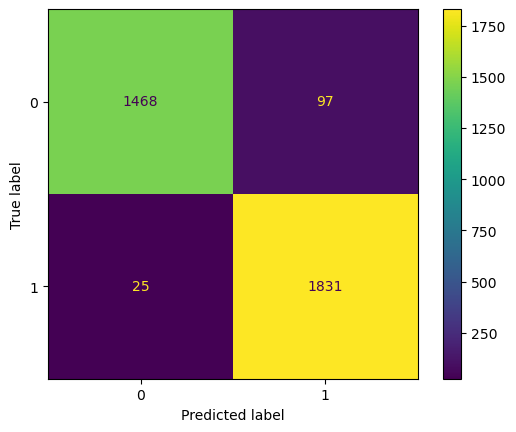

In [76]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(best_model, X_test, y_test)

## Best Model is K-Nearest Neighbor(KNN) with Accuracy 96.66%